In [1]:
from sys import path as syspath
from pathlib import Path

syspath.append(str(Path().home() / "pyref" / "src"))

import pyref as rf
import seaborn as sns
import matplotlib.pyplot as plt
import pickle as pkl
import pandas as pd
import mplcursors
import matplotlib

%matplotlib ipympl

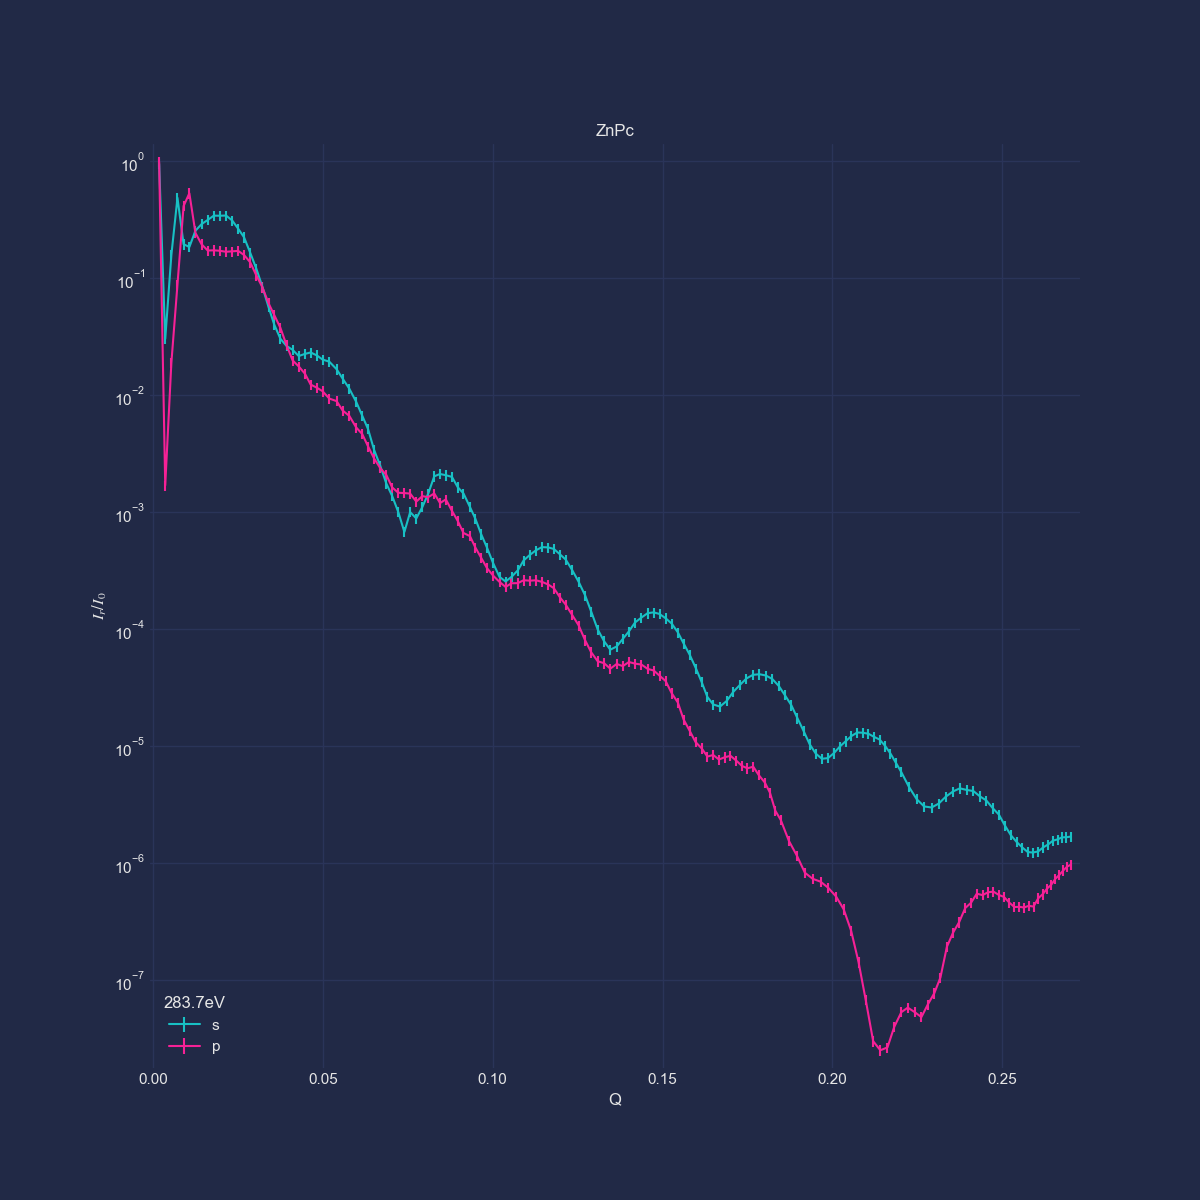

In [2]:
db = rf.db()

znpc_oc = db.get_oc("C32H16N8Zn")
znpc_mono = {
    "283.7": {
        "s": db.get_refl("ZnPc_283.7_100.0 (CCD Scan 82865).parquet", "ZnPc"),
        "p": db.get_refl("ZnPc_283.7_190.0 (CCD Scan 82869).parquet", "ZnPc"),
    },
}

fig, ax = plt.subplots(nrows = len(znpc_mono.keys()), figsize = (12, 12),sharex=True, gridspec_kw={"hspace":0})
ax = [ax]
for i, (k,v) in enumerate(znpc_mono.items()):
    v["s"].plot(ax = ax[i], x = "Q", y = "Refl", yerr = "Err", label = "s", logy = True, color = "C0")
    v["p"].plot(ax = ax[i], x = "Q", y = "Refl", yerr = "Err", label = "p", logy = True, color = "C1")

    if i == 0:
        ax[i].set(
            title = "ZnPc",
            ylabel = r"$I_r / I_0$",
        )
    elif i == len(znpc_mono.keys()) - 1:
        ax[i].set(
            xlabel = r"Q [$\AA^{-1}$]",
            ylabel = r"$I_r / I_0$",
        )
    else:
        ax[i].set(
            ylabel = r"$I_r / I_0$",
        )
    ax[i].legend(
        loc = "lower left",
        title = k + "eV",
    )
lines = ax[0].get_lines()

mplcursors.cursor(lines, hover = True)
plt.show()

# Points to remove
---

1. Low Q garbage first 6?
2. Points in the third fringe

# Slice off high Q
---
slice to just first 2 fringes

C:\Users\Harlan Heilman\AppData\Local\Temp\ipykernel_19552\2702700683.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  znpc_long_s = znpc_s[(znpc_s["Q"] != .0757)][znpc_s["Q"] != 0.0740].dropna()
C:\Users\Harlan Heilman\AppData\Local\Temp\ipykernel_19552\2702700683.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  znpc_long_p = znpc_p[(znpc_p["Q"] != .0757)][znpc_p["Q"] != 0.0740].dropna()


(<Figure size 1000x500 with 1 Axes>, <Axes: >)

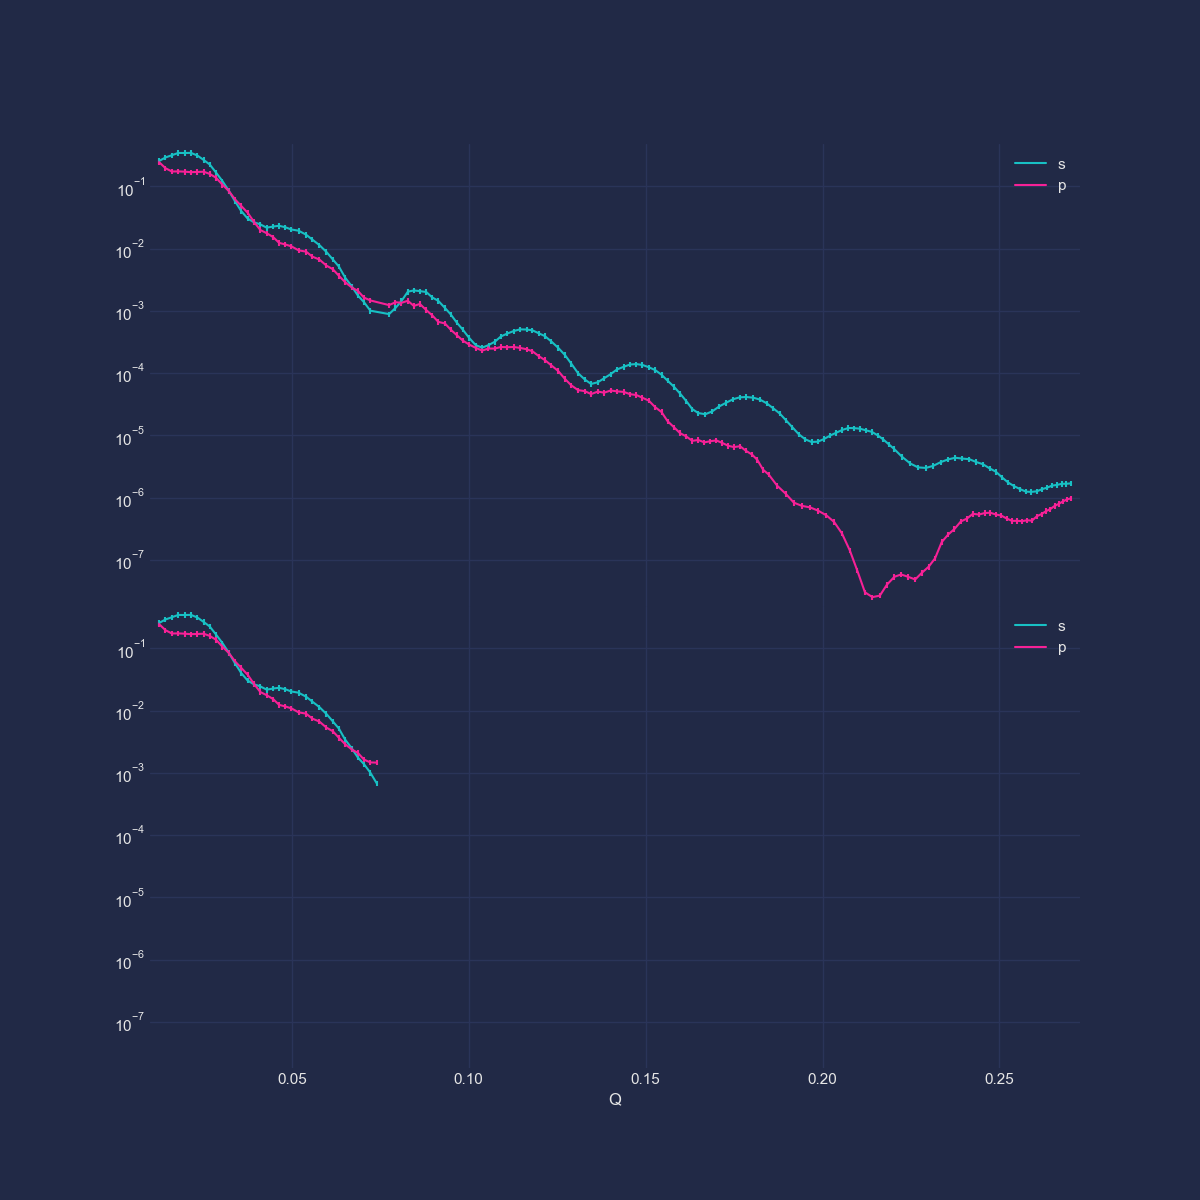

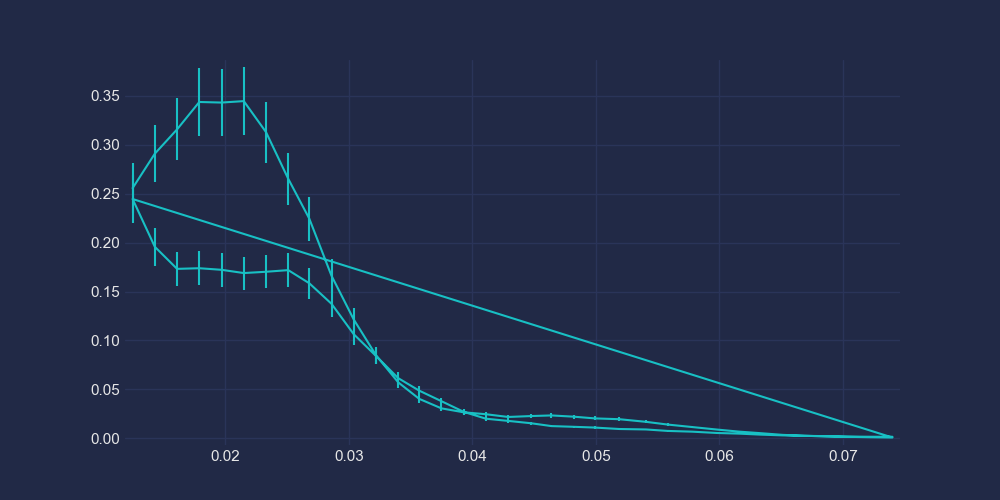

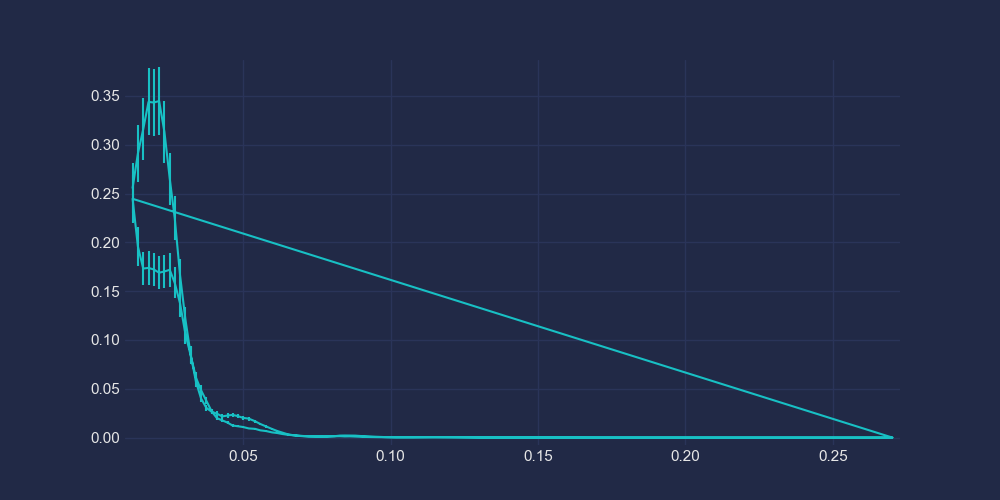

In [3]:
import matplotlib as mpl


znpc_s = znpc_mono["283.7"]["s"].iloc[6:]
znpc_p = znpc_mono["283.7"]["p"].iloc[6:]

znpc_long_s = znpc_s[(znpc_s["Q"] != .0757)][znpc_s["Q"] != 0.0740].dropna()
znpc_long_p = znpc_p[(znpc_p["Q"] != .0757)][znpc_p["Q"] != 0.0740].dropna()

znpc_short_s = znpc_s[znpc_s["Q"] < 0.075]
znpc_short_p = znpc_p[znpc_p["Q"] < 0.075]


fig, ax = plt.subplots(nrows = 2, figsize = (12, 12), sharex = True, sharey = True, gridspec_kw = {"hspace":0})

znpc_long_s.plot(x = "Q", y = "Refl", yerr = "Err", label = "s", logy = True, color = "C0", ax = ax[0])
znpc_long_p.plot(x = "Q", y = "Refl", yerr = "Err", label = "p", logy = True, color = "C1", ax = ax[0])

znpc_short_s.plot(x = "Q", y = "Refl", yerr = "Err", label = "s", logy = True, color = "C0", ax = ax[1])
znpc_short_p.plot(x = "Q", y = "Refl", yerr = "Err", label = "p", logy = True, color = "C1", ax = ax[1])
mplcursors.cursor(ax[0], hover = True)
mplcursors.cursor(ax[1], hover = True)

znpc_short = rf.to_refnx_dataset(znpc_short_s, pol = "sp", second_pol=znpc_short_p)
znpc_short.plot()
znpc_long = rf.to_refnx_dataset(znpc_long_s, pol = "sp", second_pol=znpc_long_p)
znpc_long.plot()

(<Figure size 1000x500 with 1 Axes>, <Axes: >)

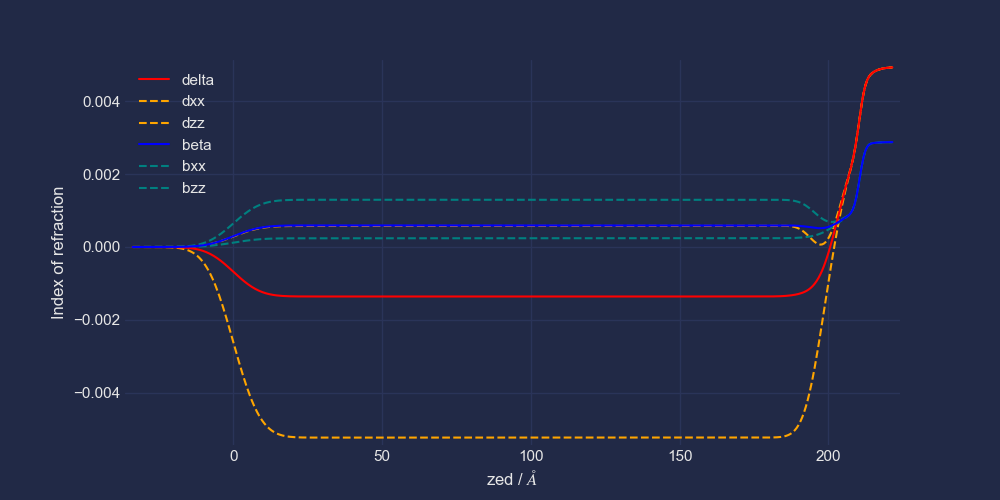

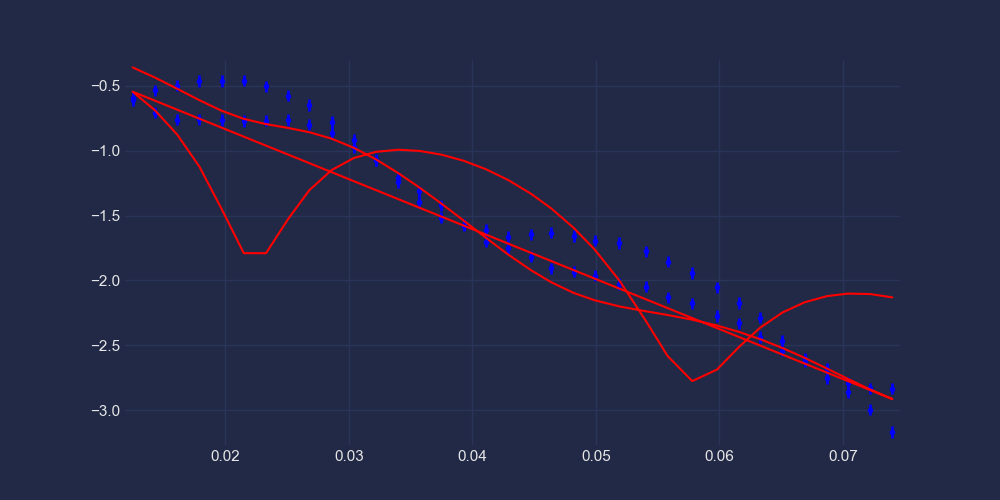

In [4]:
from pypxr.structure import *
from pypxr.reflectivity import *
from refnx.dataset import ReflectDataset
from refnx.analysis import Transform, CurveFitter, Objective, GlobalObjective
from refnx._lib.emcee.moves.de import *
from pyref.fitting.logp import LogpExtra_rough



# Collect structure parameters
znpc_mono_struct_file = db.get_struct("ZnPc_RoomTemp")
znpc_oc = db.get_oc("C32H16N8Zn")

# generate slabs
en = 283.7
vac = PXR_MaterialSLD("", 0, en)(0, 0)
si = PXR_MaterialSLD("Si", 2.3, en, name="Si")(znpc_mono_struct_file["Si"]["thickness"],znpc_mono_struct_file["Si"]["roughness"])
sio2 = PXR_MaterialSLD("SiO2", 1.6, en, name="SiO2")(znpc_mono_struct_file["SiO2"]["thickness"],znpc_mono_struct_file["SiO2"]["roughness"])
c_amor = PXR_MaterialSLD("C", 1.6, en, name="C_Amorphous")(znpc_mono_struct_file["C"]["thickness"], znpc_mono_struct_file["C"]["roughness"])

n = np.array([znpc_oc["xx"].n(en), znpc_oc["zz"].n(en)])

znpc = PXR_SLD(n, symmetry = "uni", name="ZnPc")(znpc_mono_struct_file["C32H16N8Zn"]["thickness"], znpc_mono_struct_file["C32H16N8Zn"]["roughness"])

# generate structure
struct = vac | znpc | c_amor | sio2 | si 
struct.plot()

model = PXR_ReflectModel(struct,pol="sp", scale=1, bkg=0, dq=0.0, name=f"model_{i}", energy = en)
model.scale.setp(vary=True, bounds=(0.6, 1.1))
model.bkg.setp(vary=True, bounds=(1e-9, 1e-6))

objective = Objective(model, znpc_short, transform=Transform("logY"))
objective.plot()

In [5]:
znpc.sld.xx.setp(vary = True, bounds = (-0.001, 0.001))
znpc.sld.zz.setp(vary = True, bounds = (-0.002, -0.005))

znpc.sld.ixx.setp(vary = True, bounds = (0, .002))
znpc.sld.izz.setp(vary = True, bounds = (0, .002))

100%|██████████| 200/200 [00:15<00:00, 13.26it/s]


________________________________________________________________________________
Parameters:      None      
<Parameter:    'scale'    , value=0.871148 +/- 0.0187, bounds=[0.6, 1.1]>
<Parameter:     'bkg'     , value=4.83993e-07 +/- 3.05e-07, bounds=[1e-09, 1e-06]>
<Parameter:   'ZnPc_xx'   , value=-0.000549425 +/- 5.46e-05, bounds=[-0.001, 0.001]>
<Parameter:  'ZnPc_ixx'   , value=0.00012648 +/- 1.66e-05, bounds=[0.0, 0.002]>
<Parameter:   'ZnPc_zz'   , value=-0.00200245 +/- 2.84e-06, bounds=[-0.005, -0.002]>
<Parameter:  'ZnPc_izz'   , value=0.000534942 +/- 2.87e-05, bounds=[0.0, 0.002]>


(<Figure size 1000x500 with 1 Axes>, <Axes: >)

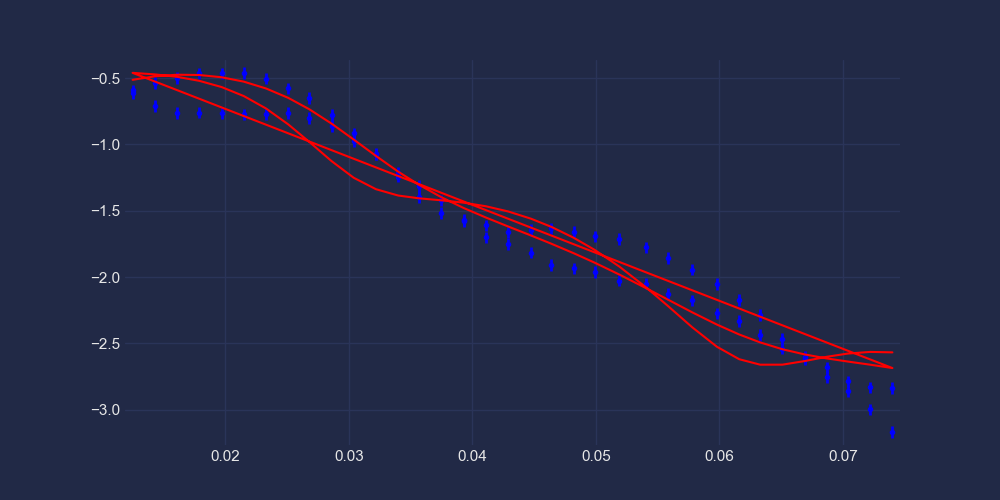

In [8]:
move = [(DEMove(sigma=1e-7), 0.95), (DEMove(sigma=1e-7), 0.05)]
nwalkers = 200
nsteps = 200
random_state = 1

fitter_1 = CurveFitter(objective, nwalkers=nwalkers, moves = move)
fitter_1.initialise("prior")
fitter_1.initialise("jitter")
fitter_1.sample(nsteps, random_state = random_state)


print(objective.varying_parameters())

objective.plot()

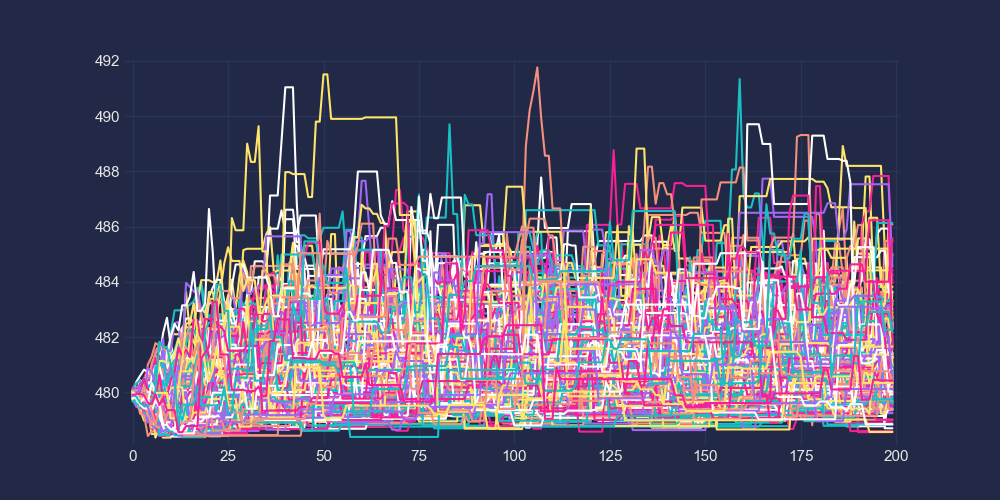

In [12]:
lp1 = fitter_1.logpost
fig, ax = plt.subplots()
ax.plot(-lp1);